In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.linalg import null_space
from scipy.stats import multivariate_normal
import torch
from PIL import Image
import time
import os
import sys
import random
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import gaussian_filter
import random
from sklearn.decomposition import PCA
import scipy.stats

import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class GaussianMixture:
  def __init__(self, mus, covs, weights):
    """
    mus: a list of K 1d np arrays (D,)
    covs: a list of K 2d np arrays (D, D)
    weights: a list or array of K unnormalized non-negative weights, signifying the possibility of sampling from each branch.
      They will be normalized to sum to 1. If they sum to zero, it will err.
    """
    self.n_component = len(mus)
    self.mus = mus
    self.covs = covs
    self.precs = [np.linalg.inv(cov) for cov in covs]
    self.weights = np.array(weights)
    self.norm_weights = self.weights / self.weights.sum()
    self.RVs = []
    for i in range(len(mus)):
      self.RVs.append(multivariate_normal(mus[i], covs[i]))
    self.dim = len(mus[0])

  def add_component(self, mu, cov, weight=1):
    self.mus.append(mu)
    self.covs.append(cov)
    self.precs.append(np.linalg.inv(cov))
    self.RVs.append(multivariate_normal(mu, cov))
    self.weights.append(weight)
    self.norm_weights = self.weights / self.weights.sum()
    self.n_component += 1

  def pdf_decompose(self, x):
    """
      probability density (PDF) at $x$.
    """
    component_pdf = []
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
        component_pdf.append(pdf)
    component_pdf = np.array(component_pdf)
    return prob, component_pdf

  def pdf(self, x):
    """
      probability density (PDF) at $x$.
    """
    prob = None
    for weight, RV in zip(self.norm_weights, self.RVs):
        pdf = weight * RV.pdf(x)
        prob = pdf if prob is None else (prob + pdf)
    # component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    # prob = np.dot(component_pdf, self.norm_weights)
    return prob

  def score(self, x):
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    scores = np.zeros_like(x)
    for i in range(self.n_component):
        # Ensure mean is broadcast correctly
        mean_expanded = np.broadcast_to(self.mus[i], x.shape)
        gradvec = - (x - mean_expanded) @ self.precs[i]
        scores += participance[:, i:i+1] * gradvec

    return scores

  def score_decompose(self, x):
    """
    Compute the grad to each branch for the score $\nabla_x \log p(x)$ for the given $x$.
    """
    component_pdf = np.array([rv.pdf(x) for rv in self.RVs]).T
    weighted_compon_pdf = component_pdf * self.norm_weights[np.newaxis, :]
    participance = weighted_compon_pdf / weighted_compon_pdf.sum(axis=1, keepdims=True)

    gradvec_list = []
    for i in range(self.n_component):
      gradvec = - (x - self.mus[i]) @ self.precs[i]
      gradvec_list.append(gradvec)
      # scores += participance[:, i:i+1] * gradvec

    return gradvec_list, participance

  def sample(self, N):
    """ Draw N samples from Gaussian mixture
    Procedure:
      Draw N samples from each Gaussian
      Draw N indices, according to the weights.
      Choose sample between the branches according to the indices.
    """
    rand_component = np.random.choice(self.n_component, size=N, p=self.norm_weights)
    all_samples = np.array([rv.rvs(N) for rv in self.RVs])
    gmm_samps = all_samples[rand_component, np.arange(N),:]
    return gmm_samps, rand_component, all_samples

In [4]:
def create_gmm_params(n_components=2, n_features=2, cov_scale=0.5, uniform_covariance=True, sharpness=1.0):
    mus = np.random.uniform(-3, 3, size=(n_components, n_features))
    weights = np.random.dirichlet(np.ones(n_components), size=1).flatten()

    covariances = []
    for _ in range(n_components):
        if uniform_covariance:
            cov_matrix = np.eye(n_features) * cov_scale
        else:
            eigenvals = np.exp(-np.arange(n_features) * sharpness) * cov_scale
            min_eigenval = 1e-6
            eigenvals = np.maximum(eigenvals, min_eigenval)

            Q = scipy.stats.special_ortho_group.rvs(n_features)
            cov_matrix = Q @ np.diag(eigenvals) @ Q.T
        covariances.append(cov_matrix)

    covs = np.array(covariances)
    return mus, covs, weights

In [ ]:
def create_manifold_gmm(n_components=10,
                       ambient_dim=2,   # embedding dimension
                       manifold_dim=2,    # intrinsic dimension
                       curvature=3.0,
                       noise_scale=0.01): # noise in normal direction

    t = np.linspace(0, np.pi, n_components)
    base_means = np.column_stack([
        t * np.cos(curvature * t),
        t * np.sin(curvature * t)
    ])

    mus = np.zeros((len(base_means), ambient_dim))
    mus[:, :base_means.shape[1]] = base_means
    weights = np.random.dirichlet(np.ones(n_components), size=1).flatten()

    covs = []
    for i, t_i in enumerate(t):
        J = compute_jacobian(t_i)
        Q, R = np.linalg.qr(J)
        P_tangent = Q @ Q.T
        P_normal = np.eye(ambient_dim) - P_tangent

        cov = (P_tangent + noise_scale * P_normal)
        covs.append(cov)

    return mus, covs, weights

def compute_jacobian(t):
    """Compute local tangent space basis for spiral."""
    J = np.array([
        [np.cos(t) - t * np.sin(t), np.sin(t) + t * np.cos(t)],
        [-np.sin(t), np.cos(t)]
    ])
    return J

In [ ]:
def compute_spiral_jacobian(t, r):
    dr_dt = -r/(2*np.pi)

    dx_dt = dr_dt * np.cos(t) - r * np.sin(t)
    dy_dt = dr_dt * np.sin(t) + r * np.cos(t)

    J = np.array([[dx_dt],
                  [dy_dt]])
    return J

def create_spiral_gmm(n_components=10, initial_radius=3.5, noise_scale=0.05):

    t = np.linspace(0, 1.9*np.pi, n_components)
    r = initial_radius * (1 - t/(2*np.pi))
    mus = []
    covs = []

    for i in range(n_components):
        x = r[i] * np.cos(t[i])
        y = r[i] * np.sin(t[i])
        mus.append(np.array([x, y]))

        J = compute_spiral_jacobian(t[i], r[i])

        J_norm = np.linalg.norm(J)
        if J_norm > 1e-10:  #only normalize if norm is not too small
            J = J / J_norm
        else:

            J = np.array([[1.0], [0.0]])

        tangent = J.flatten()
        normal = np.array([-tangent[1], tangent[0]])

        #covariance with symmetry and positive definiteness
        position_scale = max(0.1, r[i]/initial_radius)  #min scale of 0.1
        tangent_scale = 0.5 * position_scale
        normal_scale = noise_scale * position_scale

        cov = (tangent_scale * np.outer(tangent, tangent) +
               normal_scale * np.outer(normal, normal))

        cov = (cov + cov.T) / 2

        #small diagonal term to ensure positive definiteness
        cov = cov + 1e-6 * np.eye(2)

        covs.append(cov)

    mus = np.array(mus)
    weights = np.ones(n_components) / n_components

    return mus, covs, weights

mus, covs, weights = create_spiral_gmm()

for i, cov in enumerate(covs):
    if not np.allclose(cov, cov.T):
        print(f"Covariance {i} symmetry error")
        print(f"Cov {i}:\n{cov}")
    try:
        np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        print(f"Covariance {i} is not positive definite")

In [ ]:
def create_torus_gmm(n_components=20, dim=3, R=2.0, r=2.0, noise_scale=0.05):
    """
    Creates a GMM approximating a torus in dim-dimensional space.
    R: major radius
    r: minor radius
    """
    theta = np.linspace(0, 2*np.pi, n_components//2)
    phi = np.linspace(0, 2*np.pi, 2)
    theta, phi = np.meshgrid(theta, phi)
    theta = theta.flatten()
    phi = phi.flatten()

    mus = []
    covs = []

    for i in range(n_components):
        x = (R + r*np.cos(phi[i])) * np.cos(theta[i])
        y = (R + r*np.cos(phi[i])) * np.sin(theta[i])
        z = r * np.sin(phi[i])

        mu = np.zeros(dim)
        mu[:3] = [x, y, z]
        mus.append(mu)

        dphi = np.array([-r*np.sin(phi[i])*np.cos(theta[i]),
                        -r*np.sin(phi[i])*np.sin(theta[i]),
                        r*np.cos(phi[i])])
        dtheta = np.array([-(R + r*np.cos(phi[i]))*np.sin(theta[i]),
                          (R + r*np.cos(phi[i]))*np.cos(theta[i]),
                          0])

        tangent_vectors = np.zeros((dim, dim))

        tangent_vectors[:3, 0] = dphi / np.linalg.norm(dphi)
        tangent_vectors[:3, 1] = dtheta / np.linalg.norm(dtheta)

        if dim > 3:
            basis = np.eye(dim)
            current_vectors = tangent_vectors[:, :2]

            n_additional = dim - 2
            for j in range(n_additional):
                v = basis[:, j]
                for k in range(2):  #only need to make orthogonal to first 2 vectors
                    v = v - np.dot(v, current_vectors[:, k]) * current_vectors[:, k]
                v = v / np.linalg.norm(v)
                tangent_vectors[:, j+2] = v

        scales = np.ones(dim) * noise_scale
        scales[:2] *= 5  #larger variance along manifold
        cov = np.zeros((dim, dim))
        for j in range(dim):
            cov += scales[j] * np.outer(tangent_vectors[:, j], tangent_vectors[:, j])

        cov = (cov + cov.T) / 2
        cov += 1e-6 * np.eye(dim)
        covs.append(cov)

    mus = np.array(mus)
    weights = np.ones(n_components) / n_components

    return mus, covs, weights


def create_helix_gmm(n_components=20, dim=3, radius=2.0, pitch=1.0, noise_scale=0.05):

    t = np.linspace(0, 4*np.pi, n_components)

    mus = []
    covs = []

    for i in range(n_components):
        x = radius * np.cos(t[i])
        y = radius * np.sin(t[i])
        z = pitch * t[i]

        mu = np.zeros(dim)
        mu[:3] = [x, y, z]
        mus.append(mu)

        tangent = np.array([-radius*np.sin(t[i]),
                           radius*np.cos(t[i]),
                           pitch])

        tangent_vectors = np.zeros((dim, dim))

        tangent_vectors[:3, 0] = tangent / np.linalg.norm(tangent)

        basis = np.eye(dim)
        current_vectors = tangent_vectors[:, :1]

        n_additional = dim - 1
        for j in range(n_additional):
            v = basis[:, j]
            for k in range(j+1):
                if k < 1:  #only for the first tangent vector
                    v = v - np.dot(v, current_vectors[:, k]) * current_vectors[:, k]
                elif k < j:  #for previously computed additional vectors
                    v = v - np.dot(v, tangent_vectors[:, k]) * tangent_vectors[:, k]
            v = v / np.linalg.norm(v)
            tangent_vectors[:, j+1] = v

        scales = np.ones(dim) * noise_scale
        scales[0] *= 5  #larger variance along manifold
        cov = np.zeros((dim, dim))
        for j in range(dim):
            cov += scales[j] * np.outer(tangent_vectors[:, j], tangent_vectors[:, j])

        cov = (cov + cov.T) / 2
        cov += 1e-6 * np.eye(dim)
        covs.append(cov)

    mus = np.array(mus)
    weights = np.ones(n_components) / n_components

    return mus, covs, weights

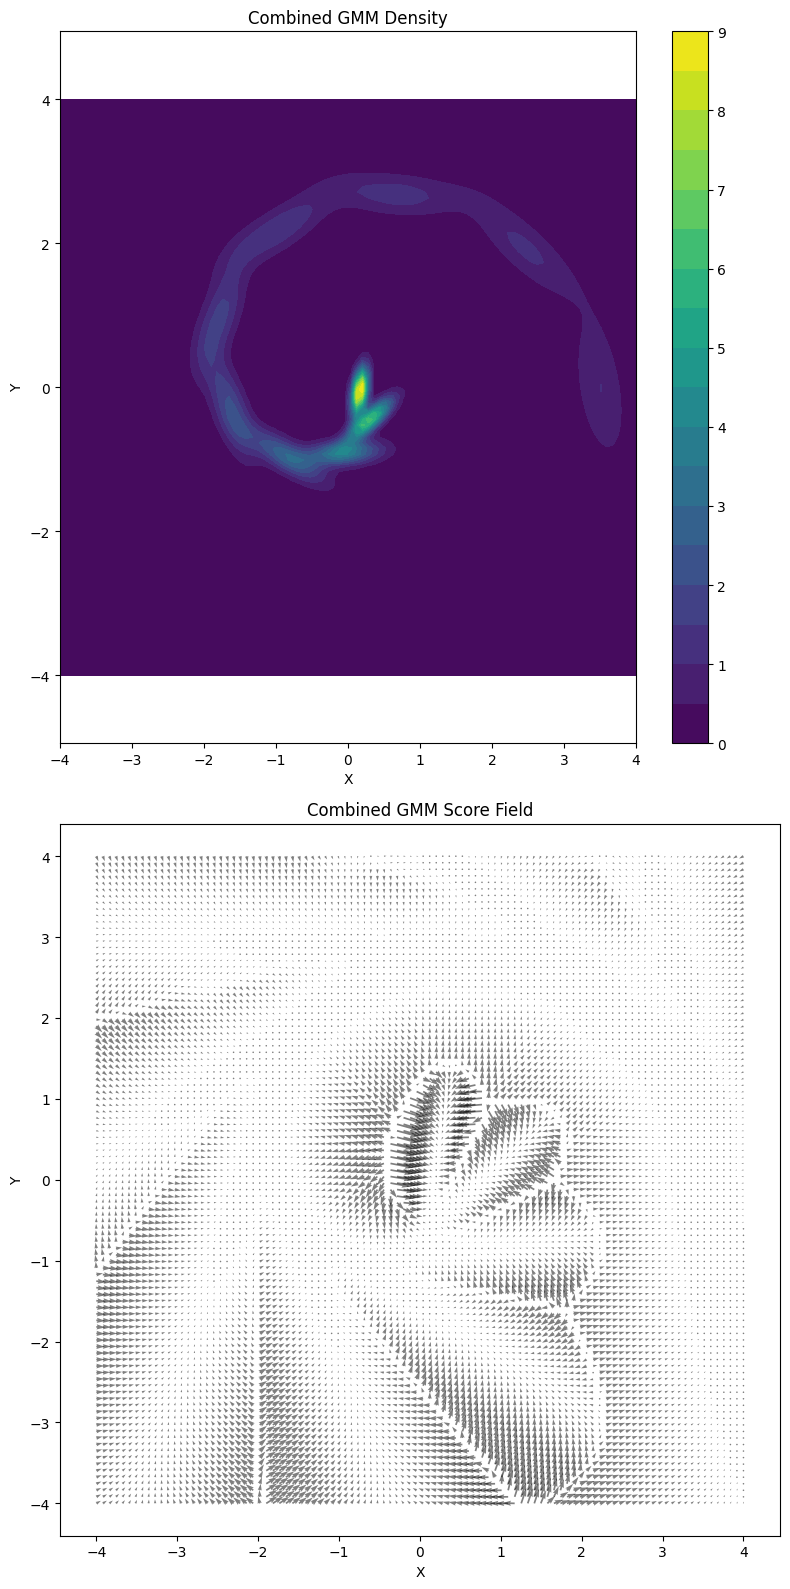

In [ ]:
def plot_gmm_combined(mus, covs, grid_size=100):
    x = np.linspace(-4, 4, grid_size)
    y = np.linspace(-4, 4, grid_size)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    total_density = np.zeros(X.shape)
    total_score_x = np.zeros(X.shape)
    total_score_y = np.zeros(X.shape)

    for mean, cov in zip(mus, covs):
        rv = multivariate_normal(mean[:2], cov[:2, :2])
        density = rv.pdf(pos)
        total_density += density

        inv_cov = np.linalg.inv(cov[:2, :2])
        score = -np.einsum('...k,kl->...l', pos - mean[:2], inv_cov)
        total_score_x += density * score[:, :, 0]
        total_score_y += density * score[:, :, 1]

    total_score_x /= total_density
    total_score_y /= total_density

    fig, axes = plt.subplots(2, 1, figsize=(8, 16))

    ax = axes[0]
    contour = ax.contourf(X, Y, total_density, levels=20, cmap='viridis')
    plt.colorbar(contour, ax=ax)
    ax.set_title('Combined GMM Density')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axis('equal')

    ax = axes[1]
    ax.quiver(X, Y, total_score_x, total_score_y, alpha=0.5)
    ax.set_title('Combined GMM Score Field')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axis('equal')

    plt.tight_layout()
    plt.show()


#mus, covs, weights = create_manifold_gmm(n_components=12, ambient_dim=2, manifold_dim=2, curvature=4.0, noise_scale=0.01)


plot_gmm_combined(mus, covs)
plt.show()


In [ ]:
dim = 3

mus, covs, weights = create_torus_gmm(dim=dim)
#mus_helix, covs_helix, weights_helix = create_helix_gmm(dim=dim)

In [ ]:
gmm = GaussianMixture(mus, covs, weights)
samples, component_indices, _ = gmm.sample(100000)
scores = gmm.score(samples)

samples_tensor = torch.from_numpy(samples).float()
scores_tensor = torch.from_numpy(scores).float()
data= {
       'samples': samples_tensor,
       'scores': scores_tensor,
       'gmm_params': {
           'mus': mus,
           'covs': covs,
           'weights': weights,
           'n_features': 3
       }
   }

torch.save(data['samples'], f'gmm_100000_samples_3d.pt')

gmm_params[f'3d_torus'] = {
            'mus': data['gmm_params']['mus'],
            'covs': data['gmm_params']['covs'],
            'weights': data['gmm_params']['weights'],
            'n_features': data['gmm_params']['n_features']
        }

In [ ]:
def generate_training_data(n_samples=10000, n_components=1, n_features=5, cov_scale=0.5, plot_samples=False, uniform_covariance=False, sharpness=1.0):
    #GMM params
    mus, covs, weights = create_gmm_params(n_components, n_features, cov_scale, uniform_covariance, sharpness)

    gmm = GaussianMixture(mus, covs, weights)

    samples, component_indices, _ = gmm.sample(n_samples)

    #calc scores for all samples
    scores = gmm.score(samples)

    samples_tensor = torch.from_numpy(samples).float()
    scores_tensor = torch.from_numpy(scores).float()

    if plot_samples:
        plt.figure(figsize=(10, 5))

        plt.subplot(121)
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, c=component_indices)
        plt.title('Generated Samples')
        plt.xlabel('x1')
        plt.ylabel('x2')

        plt.subplot(122)
        x = np.linspace(-4, 4, 20)
        y = np.linspace(-4, 4, 20)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))
        pos_reshaped = pos.reshape(-1, 2)
        score_field = gmm.score(pos_reshaped).reshape(20, 20, 2)

        plt.quiver(X, Y, score_field[:,:,0], score_field[:,:,1])
        plt.title('Score Field')
        plt.xlabel('x1')
        plt.ylabel('x2')

        plt.tight_layout()
        plt.show()

    print(f"Samples tensor shape: {samples_tensor.shape}")
    print(f"Scores tensor shape: {scores_tensor.shape}")

    return {
       'samples': samples_tensor,
       'scores': scores_tensor,
       'gmm_params': {
           'mus': mus,
           'covs': covs,
           'weights': weights,
           'n_features': n_features
       }
   }

dimensions = [2]
n_samples = 100000

for dim in dimensions:
   data = generate_training_data(
    n_samples=n_samples,
    n_components=3,
    n_features=dim,
    cov_scale=0.5,
    plot_samples=False,
    uniform_covariance=True,
    sharpness=3.0
)
   torch.save(data['samples'], f'gmm_{n_samples}_samples_{dim}d.pt')
   print(f"Saved {dim}D data")

   gmm_params[f'{dim}d'] = {
            'mus': data['gmm_params']['mus'],
            'covs': data['gmm_params']['covs'],
            'weights': data['gmm_params']['weights'],
            'n_features': data['gmm_params']['n_features']
        }

Samples tensor shape: torch.Size([100000, 2])
Scores tensor shape: torch.Size([100000, 2])
Saved 2D data


In [ ]:
torch.save(gmm_params, 'gmm_params_reference.pt')

In [5]:
working_dir = '/content/drive/MyDrive/UT_Austin/Diffusion_Models_Testing/generalization_in_diffusion_models_backup/datasets'
os.chdir(working_dir)
gmm_params = torch.load('gmm_params_reference.pt', weights_only=False)

In [6]:
gmm_params.keys()

dict_keys(['5d_diff', '100d_diff', '2d', '3d', '5d', '100d', '500d', '500d_diff', '2d_diff', '3d_diff', '2d_sharp', '3d_sharp', '5d_sharp', '100d_sharp', '500d_sharp', '2d_spiral', '2d_spiral_2', '3d_torus', '3d_helix'])

In [7]:
mus = gmm_params['100d']['mus']
covs = gmm_params['100d']['covs']
weights = gmm_params['100d']['weights']

In [8]:
gmm = GaussianMixture(mus, covs, weights)

samples, component_indices, _ = gmm.sample(200000)

samples_tensor = torch.from_numpy(samples).float()

torch.save(samples_tensor, f'gmm_200000_samples_100d.pt')

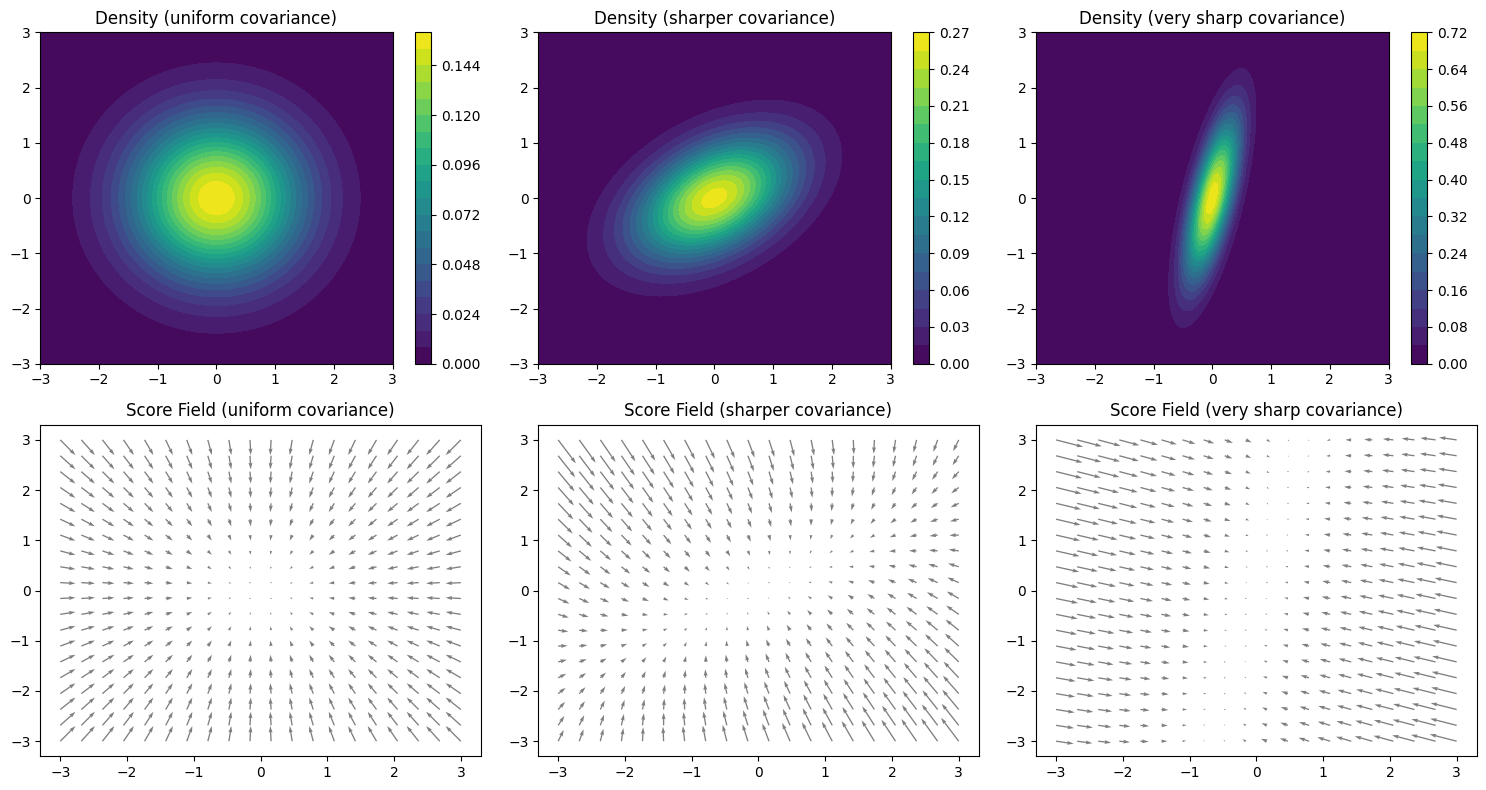

In [ ]:
def create_covariance(method, cov_scale=1.0, sharpness=3.0):
    if method == 'uniform':
        return np.eye(2) * cov_scale
    elif method == 'sharper':
        eigenvals = np.exp(-np.arange(2) * 1.0) * cov_scale
        Q = scipy.stats.special_ortho_group.rvs(2)
        return Q @ np.diag(eigenvals) @ Q.T
    elif method == 'very sharp':
        eigenvals = np.exp(-np.arange(2) * sharpness) * cov_scale
        Q = scipy.stats.special_ortho_group.rvs(2)
        return Q @ np.diag(eigenvals) @ Q.T

def plot_covariance_comparison(seed=2):
    np.random.seed(seed)
    methods = ['uniform', 'sharper', 'very sharp']
    fig, axes = plt.subplots(2, len(methods), figsize=(15, 8))

    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    for i, method in enumerate(methods):
        mean = np.zeros(2)
        cov = create_covariance(method)
        rv = multivariate_normal(mean, cov)

        ax = axes[0, i]
        Z = rv.pdf(pos)
        contour = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
        plt.colorbar(contour, ax=ax)
        ax.set_title(f'Density ({method} covariance)')

        ax = axes[1, i]
        x_score = np.linspace(-3, 3, 20)
        y_score = np.linspace(-3, 3, 20)
        X_score, Y_score = np.meshgrid(x_score, y_score)
        points = np.column_stack((X_score.ravel(), Y_score.ravel()))

        scores = -np.dot(points - mean, np.linalg.inv(cov)).reshape(X_score.shape + (2,))

        ax.quiver(X_score, Y_score, scores[:,:,0], scores[:,:,1], alpha=0.5)
        ax.set_title(f'Score Field ({method} covariance)')

        eigenvals = np.linalg.eigvals(cov)

    plt.tight_layout()
    return fig

fig = plot_covariance_comparison(seed=140)